#  Creating a DNN using pytorch Lightning
- transform datasets into Torch compatible datasets

In [106]:
from torch.utils.data import  Dataset
import pandas as pd
import torch

import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchsummary import summary


In [107]:


class TorchDataset(Dataset):

    def __init__(self,filePath):

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Read CSV
        data = pd.read_csv(filePath)

        self.X = data.iloc[:,:-1].values
        self.targets = data.iloc[:, -1].values

        # Feature Scale if you want


        # Convert to Torch Tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, item):

        return self.X[item], self.targets[item]

In [108]:
import numpy as np
# Datasets:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# Train
Hdata_train = pd.read_csv('./DATA/TRAIN_DATA.csv')
Hdata_test = pd.read_csv('./DATA/TEST_DATA.csv')
# X and y
X = Hdata_train.iloc[:,:-1].values
X = X.astype(np.float64)
y= Hdata_train.iloc[:,-1].values


## Adding Validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True,)


Hdata_train_Xtensor = torch.tensor(X_train,dtype=torch.float32,device=device)
Hdata_train_ytensor = torch.tensor(y_train,dtype=torch.float32,device=device)
Hdata_valid_Xtensor = torch.tensor(X_valid,dtype=torch.float32,device=device)
Hdata_valid_ytensor = torch.tensor(y_valid,dtype=torch.float32,device=device)


# Test
# X and y
X_test = Hdata_test.iloc[:,:-1].values
X_test = X_test.astype(np.float64)
y_test = Hdata_test.iloc[:,-1].values

# y_test = le.fit_transform(y_test)#

Hdata_test_Xtensor = torch.tensor(X_test,dtype=torch.float32,device=device)
Hdata_test_ytensor = torch.tensor(y_test,dtype=torch.float32,device=device)



# Creating the Tensor Datasets
Train_set = TensorDataset(Hdata_train_Xtensor, Hdata_train_ytensor)
Valid_set = TensorDataset(Hdata_valid_Xtensor, Hdata_valid_ytensor)
Test_set = TensorDataset(Hdata_test_Xtensor, Hdata_test_ytensor)

# class_names = Trainset.classes
# class_dict = Trainset.class_to_idx
# print('Training set classes: ',class_names, ' idx: ',class_dict)
# Creating Dataloaders
train_loader = DataLoader(Train_set,batch_size=320, shuffle= False, num_workers= 5)
test_loader = DataLoader(Test_set, batch_size=320, shuffle= False, num_workers= 5)
valid_loader = DataLoader(Valid_set, batch_size=320, shuffle= False, num_workers= 5)


cpu


In [109]:

# train_loader = DataLoader(Hdata_train,batch_size=64,)
# test_loader = DataLoader(Hdata_test,batch_size=64,)

In [110]:

class CNN1D(pl.LightningModule):
    def __init__(self, input_shape):

        self.save_hyperparameters()# to Save Hyperparameters
        super(CNN1D, self).__init__()
        self.conv1D_1 = nn.Conv1d(in_channels=1, out_channels=32, padding='same',  kernel_size=3,)
        self.maxPool1D_1 = nn.MaxPool1d(4)
        self.conv1D_2 = nn.Conv1d(in_channels=32, out_channels=32, padding='same',  kernel_size=3)
        self.maxPool1D_2 = nn.MaxPool1d(4)
        self.conv1D_3 = nn.Conv1d(in_channels=32, out_channels=16, padding='same',  kernel_size=3)
        self.maxPool1D_3 = nn.MaxPool1d(4)
        self.conv1D_4 = nn.Conv1d(in_channels=16, out_channels=16, padding='same',  kernel_size=3)
        self.maxPool1D_4 = nn.MaxPool1d(4)



        self.fc1 = nn.Linear(256, 300)
        self.fc2 = nn.Linear(300, 128)
        self.fc3 = nn.Linear(128, 31)

        self.train_accuracy = Accuracy(task='multiclass', num_classes=31)
        self.train_f1 = F1Score(task='multiclass', num_classes=31)
        self.train_precisn = Precision(task='multiclass', num_classes=31)
        self.train_rocAUC = AUROC(task='multiclass', num_classes=31)

        self.val_accuracy = Accuracy(task='multiclass', num_classes=31)
        self.val_f1 = F1Score(task='multiclass', num_classes=31)
        self.val_precisn = Precision(task='multiclass', num_classes=31)
        self.val_rocAUC = AUROC(task='multiclass', num_classes=31)

        self.test_accuracy = Accuracy(task='multiclass', num_classes=31)
        self.test_f1 = F1Score(task='multiclass', num_classes=31)
        self.test_precisn = Precision(task='multiclass', num_classes=31)
        self.test_rocAUC = AUROC(task='multiclass', num_classes=31)
        self.confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=31)


    def forward(self, x):
        # block 1
        x = self.conv1D_1(x)
        x = torch.relu(x)
        x= self.maxPool1D_1(x)


        # block 2
        x = self.conv1D_2(x)
        x = torch.relu(x)
        x= self.maxPool1D_2(x)

        # block 3
        x = self.conv1D_3(x)
        x = torch.relu(x)
        x= self.maxPool1D_3(x)

        # block 4
        x = self.conv1D_4(x)
        x = torch.relu(x)
        x= self.maxPool1D_4(x)

        # Flatten

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.unsqueeze(dim=1)

        y_pred = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_pred,y.long())
        self.log('train_loss', loss, on_epoch=True, on_step=True,prog_bar=True)
        self.log('train_acc_step', self.train_accuracy(y_pred, y.long(), ), on_epoch=True, on_step=True,prog_bar=False)
        self.log('train_f1_step', self.train_f1(y_pred, y.long(), ), on_epoch=True, on_step=True,prog_bar=False)
        self.log('train_precision_step', self.train_precisn(y_pred, y.long(), ), on_epoch=True, on_step=True,)
        self.log('train_auc_step', self.train_rocAUC(y_pred, y.long(), ), on_epoch=True, on_step=True,prog_bar=False )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.unsqueeze(dim=1)
        y_pred = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_pred,y.long())
        self.log('validation_loss', loss)
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', self.val_accuracy(y_pred, y.long(), ),on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y_pred, y.long(), ),on_epoch=True, prog_bar=True)
        self.log('val_precision', self.val_precisn(y_pred, y.long(), ),on_epoch=True, prog_bar=True)
        self.log('val_auc', self.val_rocAUC(y_pred, y.long(), ),on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x = x.unsqueeze(dim=1)
        # img = x.view(-1,3,IMG_SIZE,IMG_SIZE)
        y_pred = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_pred,y.long())
        # self.log('test_loss', loss)
        # self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', self.test_accuracy(y_pred, y.long(), ),)
        self.log('test_f1', self.test_f1(y_pred, y.long(), ),)
        self.log('test_precision', self.test_precisn(y_pred, y.long(), ),)
        self.log('test_auc', self.test_rocAUC(y_pred, y.long(), ),)
        self.confusion_matrix(y_pred, y.long())
        print(self.confusion_matrix)
        # self.logger.experiment.add_confusion_matrix('confusion_matrix', self.confusion_matrix)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer



In [111]:

# model
import torchsummary

from torchmetrics import Accuracy, F1Score, Precision, AUROC, ConfusionMatrix
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.loggers import WandbLogger,TensorBoardLogger
## tensorboard --logdir tb_logs
# tb_logger = TensorBoardLogger("tb_logs", name="1D_CNN")
# wandb_logger = WandbLogger(project="DL_Droid", log_model=True) # log_model logs model checkpoints

model1 = CNN1D(input_shape=len(train_loader.dataset[0][0]),)



# wandb_logger.watch(model1, log="all")




trainer = pl.Trainer(max_epochs=150, min_epochs=80, accelerator="gpu" if torch.cuda.is_available() else'cpu', devices=1,callbacks=[
    EarlyStopping(monitor="val_loss", mode="min",)
],)
trainer.fit(model=model1, train_dataloaders=train_loader,val_dataloaders=valid_loader)
trainer.test(model=model1, dataloaders=test_loader)





# torchsummary.summary(model1, (419,))
# print(summary(model1,(len(train_loader.dataset.X[0]),1)))

# train model
# trainer = pl.Trainer()
# trainer.fit(model=model1, train_dataloaders=train_loader)
# trainer.test(model=model1, dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name             | Type                      | Params
----------------------------------------------------------------
0  | conv1D_1         | Conv1d                    | 128   
1  | maxPool1D_1      | MaxPool1d                 | 0     
2  | conv1D_2         | Conv1d                    | 3.1 K 
3  | maxPool1D_2      | MaxPool1d                 | 0     
4  | conv1D_3         | Conv1d                    | 1.6 K 
5  | maxPool1D_3      | MaxPool1d                 | 0     
6  | conv1D_4         | Conv1d                    | 784   
7  | maxPool1D_4      | MaxPool1d                 | 0     
8  | fc1              | Linear                    | 77.1 K
9  | fc2              | Linear                    | 38.5 K
10 | fc3              | Linear                    | 4.0 K 
11 | train_accuracy   | MulticlassAccuracy        | 0     
12 | train_f1       

Sanity Checking: 0it [00:00, ?it/s]

/Users/dulcedeleche/opt/anaconda3/envs/Pytorch39/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Users/dulcedeleche/opt/anaconda3/envs/Pytorch39/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=80` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

MulticlassConfusionMatrix()
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9451612830162048
        test_auc            0.9992042779922485
         test_f1            0.9451612830162048
     test_precision         0.9451612830162048
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9451612830162048,
  'test_f1': 0.9451612830162048,
  'test_precision': 0.9451612830162048,
  'test_auc': 0.9992042779922485}]

In [112]:
trainer.test(model=model1, dataloaders=test_loader)


Testing: 0it [00:00, ?it/s]

MulticlassConfusionMatrix()
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9451612830162048
        test_auc            0.9992042779922485
         test_f1            0.9451612830162048
     test_precision         0.9451612830162048
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9451612830162048,
  'test_f1': 0.9451612830162048,
  'test_precision': 0.9451612830162048,
  'test_auc': 0.9992042779922485}]

In [113]:

cm = model1.confusion_matrix.confmat.detach().numpy().astype(int)
cm

array([[20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  

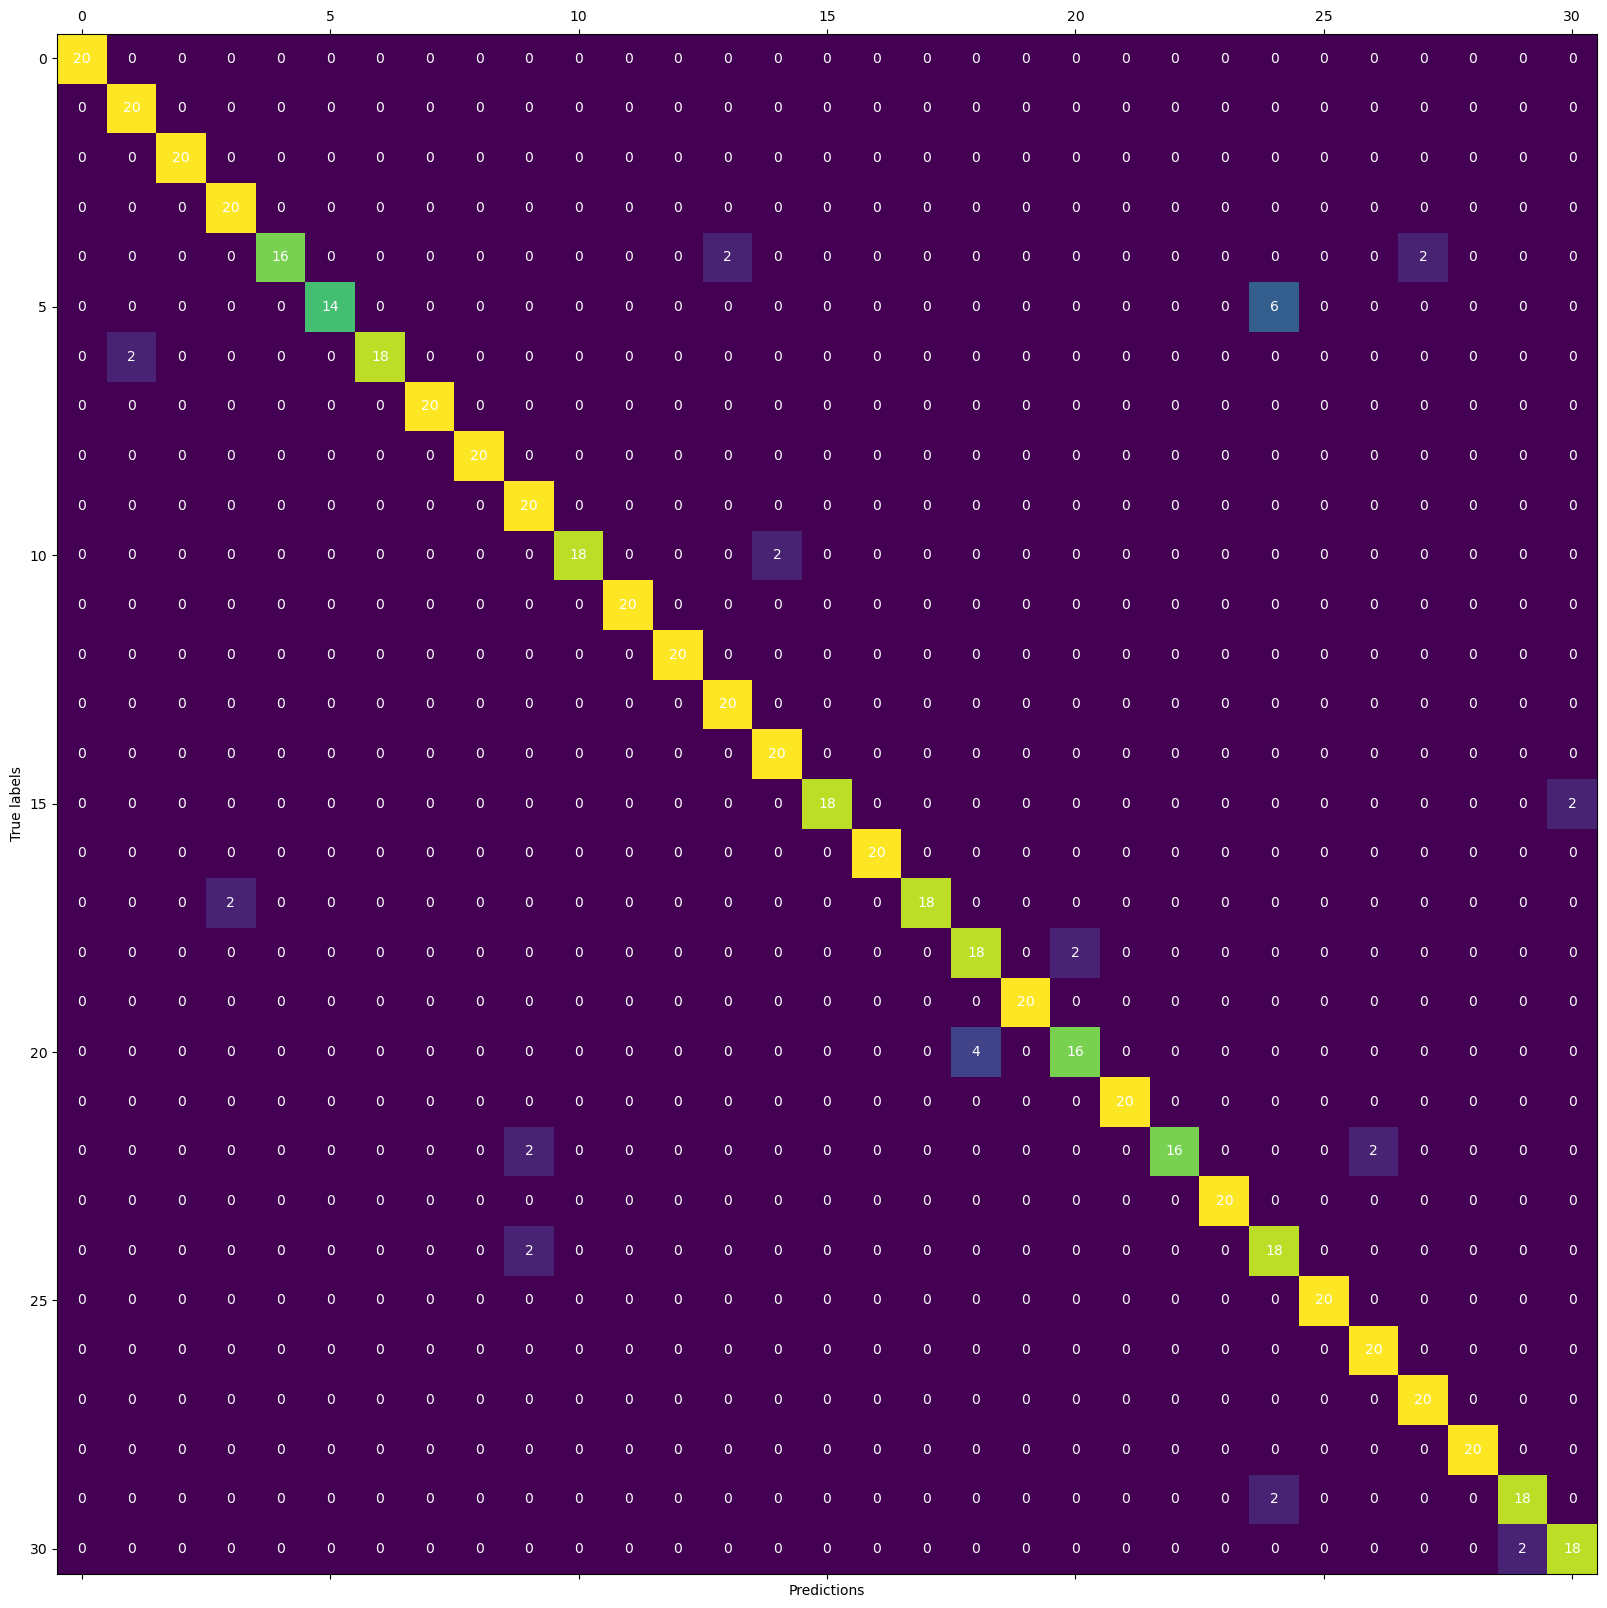

<Figure size 640x480 with 0 Axes>

In [114]:
import matplotlib.pyplot as plt

import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(20, 20),)
loc = plticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.matshow(cm, )

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center',color ='w')

plt.xlabel('Predictions')
plt.ylabel('True labels')
plt.show()
plt.savefig('Confusion_Matrix_Joint.png')

In [115]:
type(cm)

numpy.ndarray